In [1]:
!nvidia-smi

Sat Nov 25 10:08:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.1 MB/s eta 0:00:00


In [5]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [7]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

In [8]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [10]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [12]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [13]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


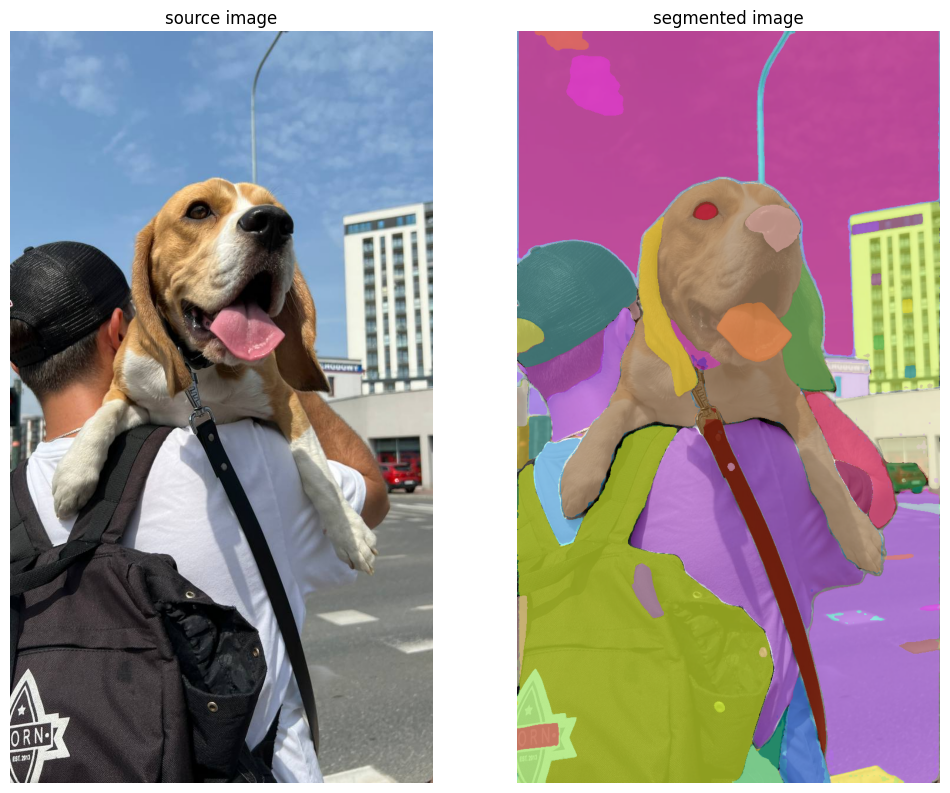

In [14]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

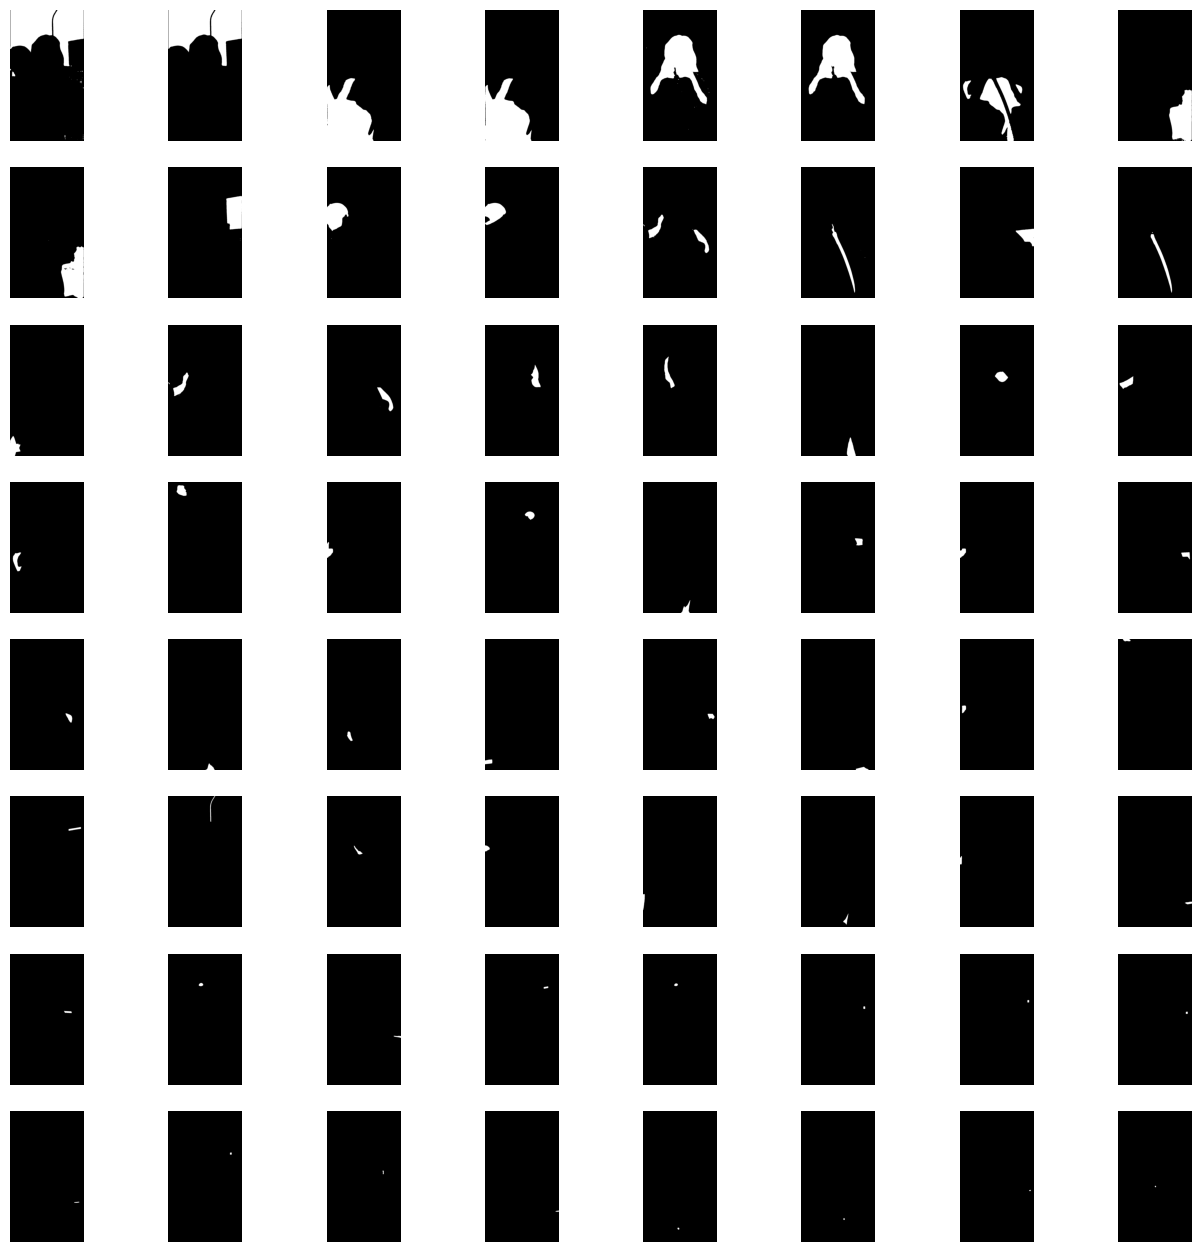

In [15]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

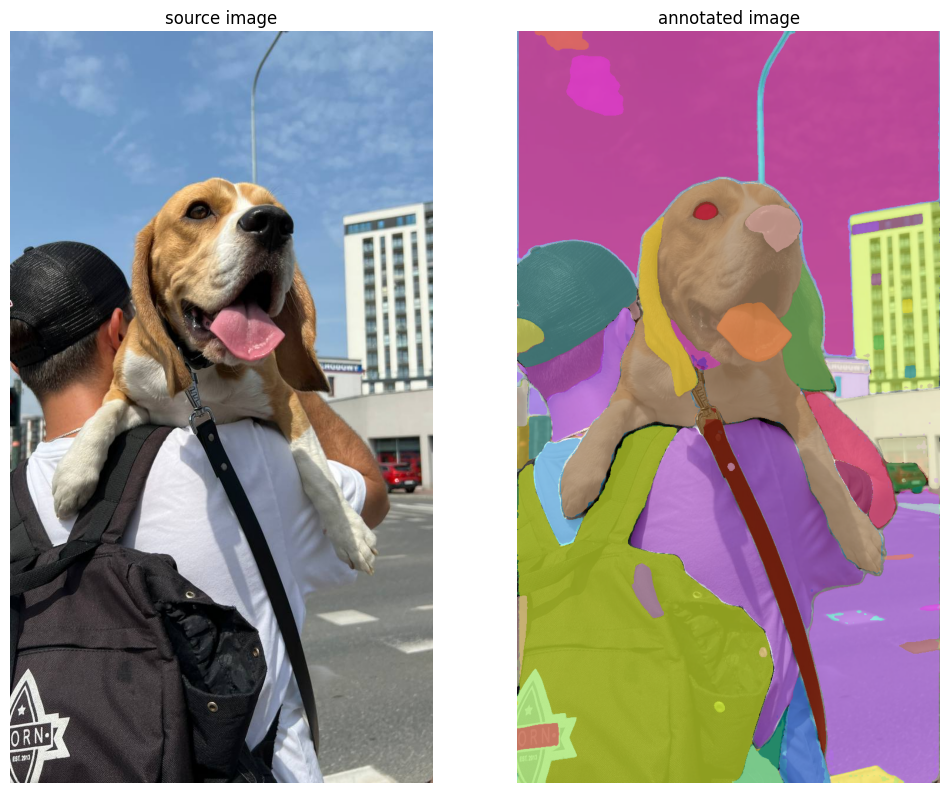

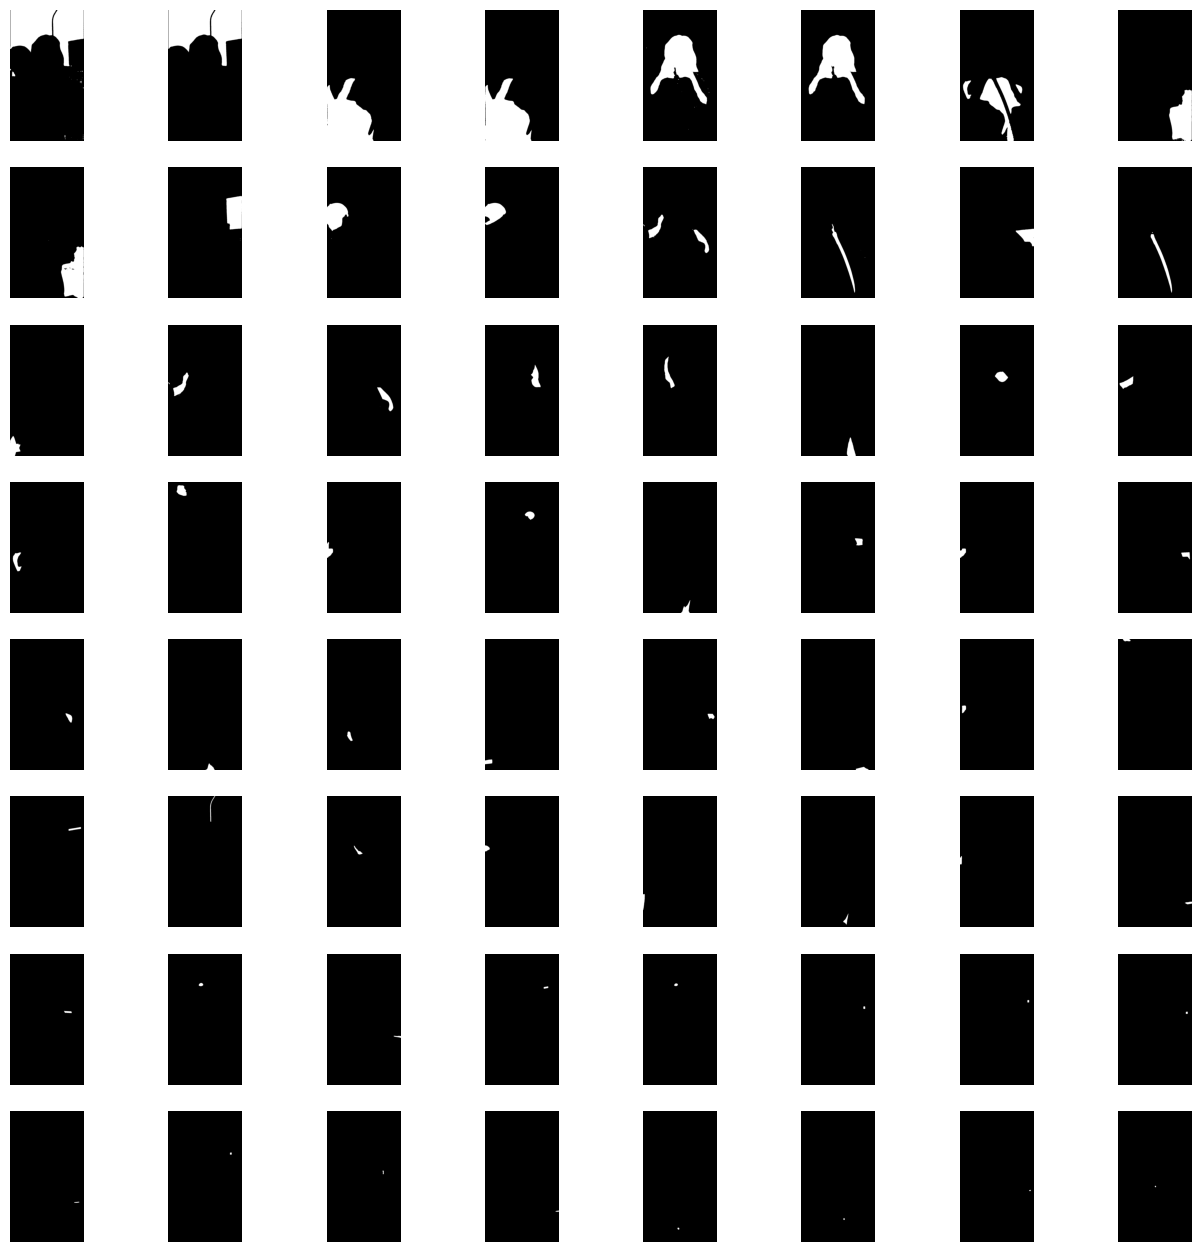

In [28]:
import os
import cv2
import torch
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

class ImageSegmentation:
    def __init__(self, model_type="vit_h", checkpoint_path=None):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model_type = model_type
        self.checkpoint_path = checkpoint_path
        self._load_model()

    def _load_model(self):
        if self.checkpoint_path is None:
            raise ValueError("Please provide a valid checkpoint path.")

        self.sam = sam_model_registry[self.model_type](checkpoint=self.checkpoint_path).to(device=self.device)
        self.mask_generator = SamAutomaticMaskGenerator(self.sam)

    def segment_image(self, image_path):
        image_bgr = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        sam_result = self.mask_generator.generate(image_rgb)

        mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
        detections = sv.Detections.from_sam(sam_result=sam_result)
        annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

        return image_bgr, annotated_image, sam_result

if __name__ == "__main__":
    # Example usage
    home = os.getcwd()
    checkpoint_path = os.path.join(home, "weights", "sam_vit_h_4b8939.pth")
    image_name = "dog.jpeg"
    image_path = os.path.join(home, "data", image_name)

    segmentation_model = ImageSegmentation(model_type="vit_h", checkpoint_path=checkpoint_path)
    source_image, annotated_image, sam_result = segmentation_model.segment_image(image_path)

    # Visualize source image, annotated image, and segmented image
    sv.plot_images_grid(
        images=[source_image, annotated_image],
        grid_size=(1, 2),
        titles=['source image', 'annotated image']
    )

    # Visualize individual masks
    masks = [
        mask['segmentation']
        for mask
        in sorted(sam_result, key=lambda x: x['area'], reverse=True)
    ]

    sv.plot_images_grid(
        images=masks,
        grid_size=(8, int(len(masks) / 8)),
        size=(16, 16)
    )


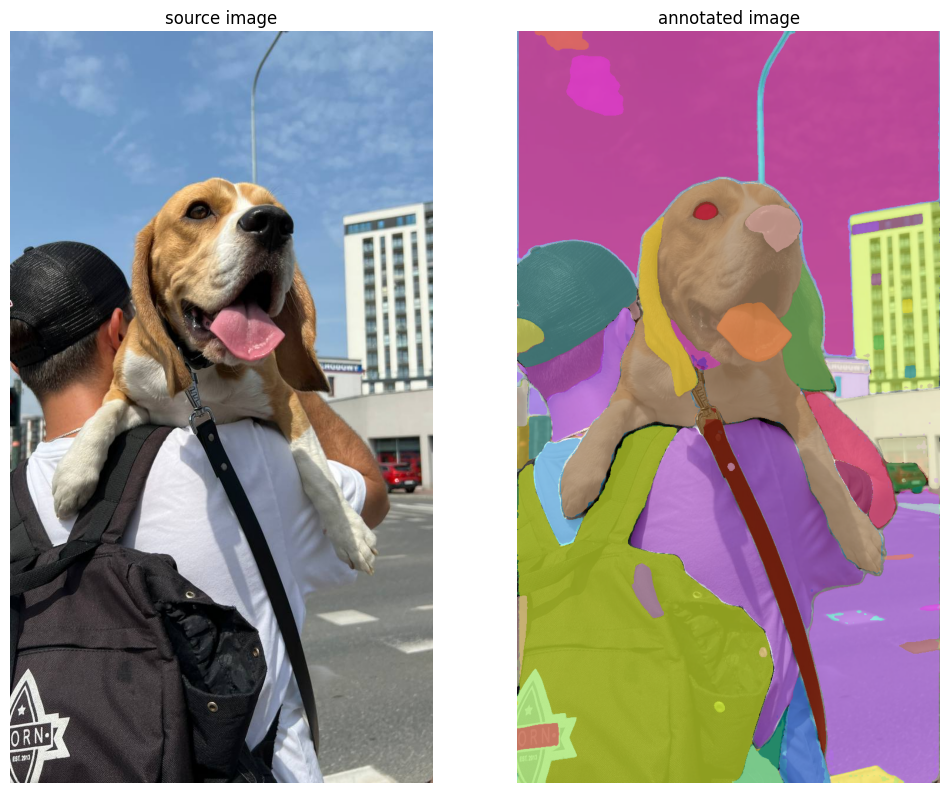

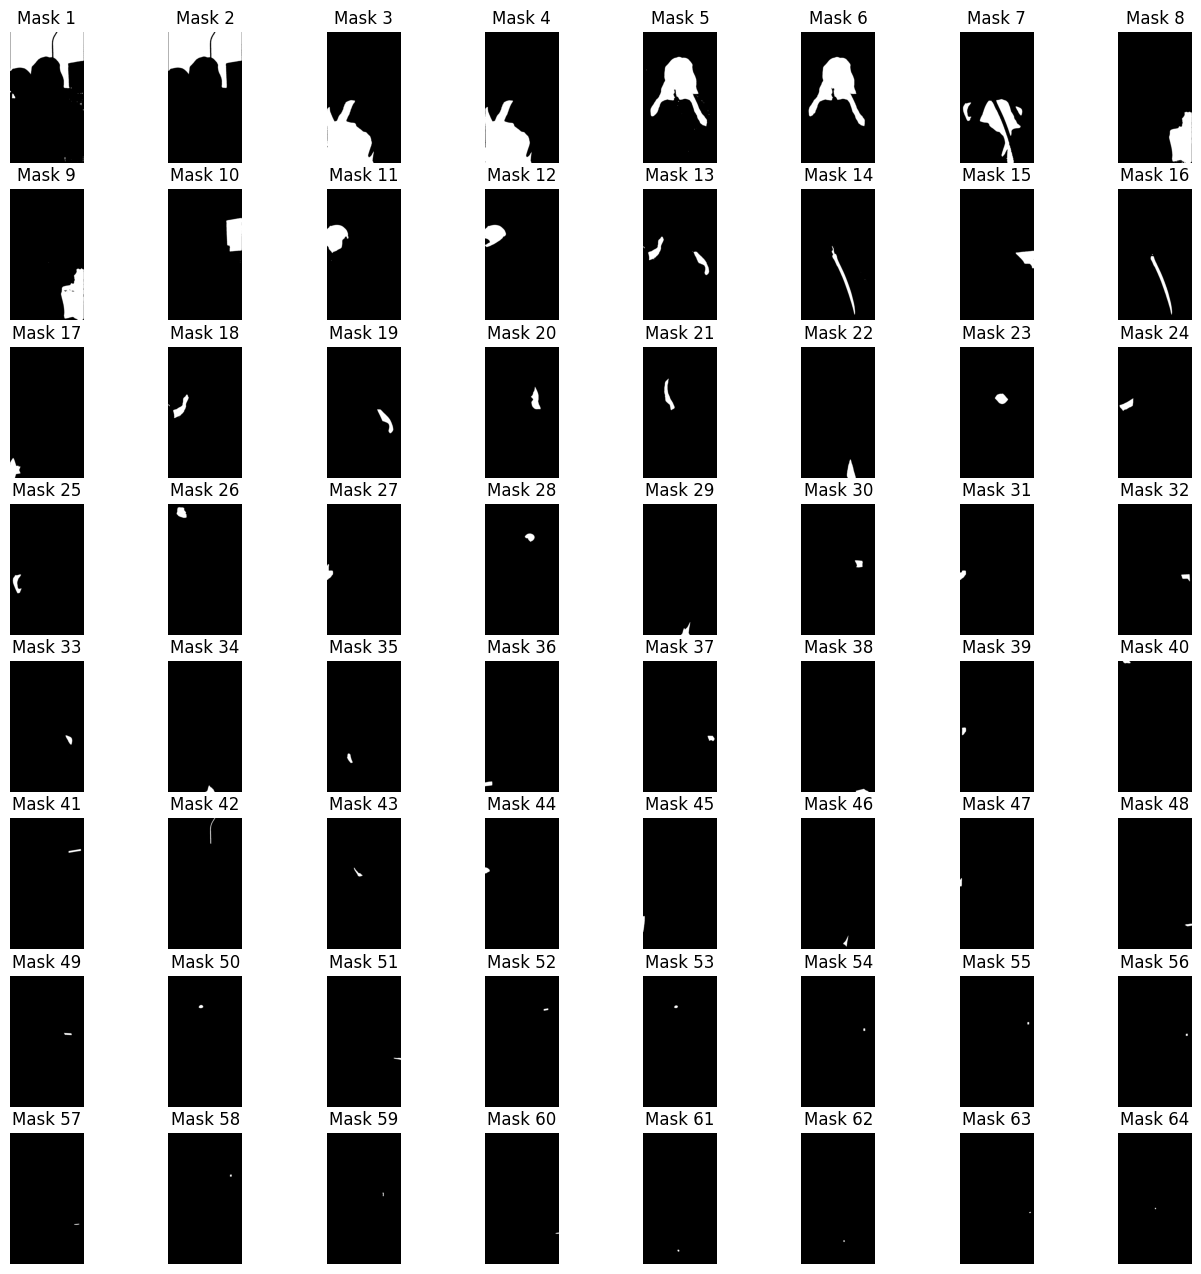

In [30]:
import os
import cv2
import torch
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

class ImageSegmentation:
    def __init__(self, model_type="vit_h", checkpoint_path=None, grid_size=(1, 2), mask_grid_size=(8, 8), mask_size=(16, 16), color_lookup=sv.ColorLookup.INDEX):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model_type = model_type
        self.checkpoint_path = checkpoint_path
        self.grid_size = grid_size
        self.mask_grid_size = mask_grid_size
        self.mask_size = mask_size
        self.color_lookup = color_lookup
        self._load_model()

    def _load_model(self):
        if self.checkpoint_path is None:
            raise ValueError("Please provide a valid checkpoint path.")

        self.sam = sam_model_registry[self.model_type](checkpoint=self.checkpoint_path).to(device=self.device)
        self.mask_generator = SamAutomaticMaskGenerator(self.sam)

    def load_model(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self._load_model()

    def segment_image(self, image_path):
        image_bgr = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        sam_result = self.mask_generator.generate(image_rgb)

        mask_annotator = sv.MaskAnnotator(color_lookup=self.color_lookup)
        detections = sv.Detections.from_sam(sam_result=sam_result)
        annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

        return image_bgr, annotated_image, sam_result

if __name__ == "__main__":
    # Example usage
    home = os.getcwd()
    checkpoint_path = os.path.join(home, "weights", "sam_vit_h_4b8939.pth")
    image_name = "dog.jpeg"
    image_path = os.path.join(home, "data", image_name)

    segmentation_model = ImageSegmentation(model_type="vit_h", checkpoint_path=checkpoint_path)
    source_image, annotated_image, sam_result = segmentation_model.segment_image(image_path)

    # Visualize source image and annotated image
    sv.plot_images_grid(
        images=[source_image, annotated_image],
        grid_size=segmentation_model.grid_size,
        titles=['source image', 'annotated image']
    )

    # Visualize individual masks with numbering
    masks = [
        {'mask': mask['segmentation'], 'area': mask['area']}
        for mask
        in sorted(sam_result, key=lambda x: x['area'], reverse=True)
    ]

    numbered_masks = [
        {'mask': mask['mask'], 'number': idx + 1}
        for idx, mask in enumerate(masks)
    ]

    sv.plot_images_grid(
        images=[mask['mask'] for mask in numbered_masks],
        grid_size=segmentation_model.mask_grid_size,
        size=segmentation_model.mask_size,
        titles=[f'Mask {mask["number"]}' for mask in numbered_masks]
    )
